# Equipment Held and Failed Durations
Historically it's been difficult to get some manufacturing business metrics, specifically equpiment held and failed durations. This is not possible in Excel without going into the realms of VBA, so this notebook crawls through the data and returns the duration of interest.

The duration output is used to prioritize investment/improvement projects.

## Library imports and notebook set up

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import copy
import csv
import datetime
import re
import pyodbc
import sqlalchemy

sns.set_context('poster')
pd.set_option('display.max_colwidth', 150)

## SQL statement

In [18]:
query = '''
(select Batchid, eventtype, eventdescr, occurdate, occurtime, unit, action
from Lotprompts

where
    occurtime > '01-01-2016' and
    batchid like 'L_1659___'
)

union all

(select Batchid, null as eventtype, eventdescr, occurdate, occurtime, unit, action
from Lotstatechanges

where
    occurtime > '01-01-2016' and
    batchid like 'L_1659___'
)

union all

(select Batchid, null as eventtype, eventdescr, occurdate, occurtime, unit, action
from LotReports

where
    occurtime > '01-01-2016' and
    batchid like 'L_1659___'
)

order by Batchid, occurtime
'''

## Reading data file

In [19]:
engine = sqlalchemy.create_engine('mssql+pyodbc://uslhincuity/B5DataTables?driver=SQL+Server')
connection = engine.connect()
data_df = pd.read_sql_query(query,connection)
connection.close()

In [20]:
data_df.tail()

,Batchid,eventtype,eventdescr,occurdate,occurtime,unit,action
623883,LR1659266,None,State Changed: RUNNING,2016-08-17,2016-08-17 15:11:51,V-007,\\FR_V_NG\V007_PPT_FR1_UP:1-1\\\
623884,LR1659266,None,State Changed: RUNNING,2016-08-17,2016-08-17 15:11:51,V-007,\\FR_V_NG\V007_PPT_FR1_UP:1-1\PPT_FR1_OP:1-1\\
623885,LR1659266,None,State Changed: COMPLETE,2016-08-17,2016-08-17 15:11:51,NULL_UNIT,\\FR_V_NG\FRV_INIT_UP:1-1\\\
623886,LR1659266,None,State Changed: RUNNING,2016-08-17,2016-08-17 15:11:53,V-007,\\FR_V_NG\V007_PPT_FR1_UP:1-1\PPT_FR1_OP:1-1\PPT_INIT_PH:1-1\
623887,LR1659266,Operator Prompt,"Bioburden, Tech Services, and pH samples pulled. (~D~G7~) 0 phase_boolean",2016-08-17,2016-08-17 15:12:07,V-007,\\FR_V_NG\V007_PPT_FR1_UP:1-1\PPT_FR1_OP:1-1\PPT_INIT_PH:1-1\


## Data wrangling and cleaning

In [21]:
# Grouping the data frame by batchid
# The \xef\xbb\xbf is from the encoding used to create the file, just have to include it.
groupedData = data_df.groupby('Batchid')

# Storing total number of lots into a list
groupList = data_df.groupby('Batchid').indices.keys()
groupList.sort()

print 'There are {} lots in the data.'.format(len(groupList))

There are 265 lots in the data.


In [22]:
# Converting the occurtime column to datetime objects
def convertDateTime(x):
    return pd.to_datetime(x,format='%Y-%m-%d %H:%M:%S')

data_df['occurtime'] = data_df['occurtime'].apply(lambda x: pd.to_datetime(x,format='%Y-%m-%d %H:%M:%S'))

## Data analysis

### Helper functions

In [23]:
# For different equipment (vessels, filter presses, centrifuges), different criteria is needed to pull the correct times
def getStartTime_FP2(data):
    startTime = data[data['action'].str.contains('FP_PRECOND:1-') &
                     data['unit'].str.contains('FP002') &
                     data['eventdescr'].str.contains('RUNNING')]['occurtime']

    startIndex = startTime.index.min()
    return (startIndex, startTime.min())

def getEndTime_FP2(data):
    endTime = data[data['eventdescr'].str.contains('Do you want to REPEAT the External Rinse?') &
                   data['eventdescr'].str.contains('0 phase_boolean') &
                   data['unit'].str.contains('FP002')]['occurtime']
    endIndex = endTime.index.max()
    return (endIndex,endTime.max())

### Starting and ending times calculation function

In [24]:
def getStartEndTimes_FP2(data):
    result = []
    lotNumber = data['Batchid'].iloc[0]
    result = {'BatchID':lotNumber,
               'Start Time':'',
               'End Time':'',
               'Start to End (hrs)':''}
    startIndex, startTime = getStartTime_FP2(data)
    endIndex, endTime = getEndTime_FP2(data)
    
    if np.isnan(startIndex) or np.isnan(endIndex):
        print 'Start Index is {} and End Index is {} for lot: {}'.format(startIndex, endIndex, lotNumber)
        return result
    else:
        result['Start Time'] = startTime
        result['End Time'] = endTime
        startToEnd = endTime - startTime
        startToEnd = round(startToEnd.days / 24.0 + startToEnd.seconds / 3600.0, 2)
        result['Start to End (hrs)'] = startToEnd
    
        return result

### Starting and ending times main function

In [25]:
startAndEndTimesInfo = []
for i in range(len(groupList)):
    startAndEndTimesInfo.append(getStartEndTimes_FP2(groupedData.get_group(groupList[i])))
    
startAndEndtimesInfo_df = pd.DataFrame(startAndEndTimesInfo)

Start Index is 410148 and End Index is nan for lot: LB1659260
Start Index is nan and End Index is nan for lot: LB1659262
Start Index is nan and End Index is nan for lot: LB1659263
Start Index is nan and End Index is nan for lot: LB1659264
Start Index is nan and End Index is nan for lot: LR1659120
Start Index is nan and End Index is nan for lot: LR1659261
Start Index is nan and End Index is nan for lot: LR1659266


### Area to check starting and ending times results

In [26]:
startAndEndtimesInfo_df.head()

,BatchID,End Time,Start Time,Start to End (hrs)
0,LB1659001,2016-01-12 01:10:49,2016-01-11 18:47:00,6.4
1,LB1659003,2016-01-14 00:56:53,2016-01-13 16:42:40,8.24
2,LB1659004,2016-01-15 00:18:22,2016-01-14 18:08:39,6.16
3,LB1659005,2016-01-16 12:32:03,2016-01-16 05:36:24,6.93
4,LB1659007,2016-01-17 15:10:15,2016-01-17 08:43:07,6.45


### Held duration calculation function

In [27]:
def getHeldDurations_FP2(data):
    # Data is a panda dataframe with only data for 1 batchid
    # We need to first get the starting index and the ending index because 
    # we have very specific definitions as to when the process starts and end.
    startIndex, startTime = getStartTime_FP2(data)
    endIndex, endTime = getEndTime_FP2(data)
    
    heldFlag = 0 # 0 = first held, 1 = first run
    heldDuration = 0.0
    holdStartTime = 0
    holdEndTime = 0
    
    lotNumber = data['Batchid'].iloc[0]

    results = []
    result = {'BatchID':lotNumber,
              'Held Start Time':0,
              'Held End Time':0,
              'Held Duration (hrs)':0.0,
              'Action':''} 

    # For lots that didn't start or end, the index might be Nan.
    if np.isnan(startIndex) or np.isnan(endIndex):
        heldDuration = 0.0
        print 'Start Index is {} and End Index is {} for lot: {}'.format(startIndex, endIndex, lotNumber)
        return results
    else:
        for i in range(startIndex,endIndex+1):
            eventDescr = data['eventdescr'][i]
            occurTime = data['occurtime'][i]
            action = data['action'][i]
            unit = data['unit'][i]
            
            if unit == 'FP002':
                # Look for first holding
                if heldFlag == 0:
                    if 'State Changed:  HELD' in eventDescr:
                        holdStartTime = occurTime
                        heldFlag = 1 # Set to look for first running

                # Now look for first running
                elif heldFlag == 1:
                    if 'State Changed:  RUNNING' in eventDescr:
                        holdEndTime = occurTime
                        heldFlag = 0 # Set to look for first holding
                        heldTime = (holdEndTime-holdStartTime)
                        heldTime = round(heldTime.days/24.0 + heldTime.seconds/3600.0,2)
                        result['Held Duration (hrs)'] = heldTime
                        result['Held Start Time'] = holdStartTime
                        result['Held End Time'] = holdEndTime
                        result['Action'] = action
                        results.append(copy.deepcopy(result))

    return results

### Held duration main function

In [28]:
# Main code to get Held durations
heldDurationInfo = []
heldDurationInfo_df = pd.DataFrame()

for i in range(len(groupList)):
    temp = getHeldDurations_FP2(groupedData.get_group(groupList[i]))
    if len(temp) > 0:
        for j in temp:
            heldDurationInfo.append(j)

heldDurationInfo_df = pd.DataFrame(heldDurationInfo)

Start Index is 410148 and End Index is nan for lot: LB1659260
Start Index is nan and End Index is nan for lot: LB1659262
Start Index is nan and End Index is nan for lot: LB1659263
Start Index is nan and End Index is nan for lot: LB1659264
Start Index is nan and End Index is nan for lot: LR1659120
Start Index is nan and End Index is nan for lot: LR1659261
Start Index is nan and End Index is nan for lot: LR1659266


### Area to check held duration results

In [29]:
heldDurationInfo_df.head()

,Action,BatchID,Held Duration (hrs),Held End Time,Held Start Time
0,\\FR_V_NG\FP002_UP:1-1\FP_FRIV1_OP:1-1\FP_PRECOND:1-1\,LB1659001,0.17,2016-01-11 19:15:19,2016-01-11 19:05:23
1,\\FR_V_NG\FP002_UP:1-1\FP_FRIV1_OP:1-1\FP_PRECOND:1-1\,LB1659052,0.04,2016-02-27 20:30:06,2016-02-27 20:27:24
2,\\FR_V_NG\FP002_UP:1-1\FP_FRIV1_OP:1-1\FP_POST_WASH:1-1\,LB1659074,0.03,2016-03-27 03:38:44,2016-03-27 03:36:44
3,\\FR_V_NG\FP002_UP:1-1\FP_FRIV1_OP:1-1\FP_POST_WASH:1-1\,LB1659077,0.11,2016-03-15 23:36:56,2016-03-15 23:30:28
4,\\FR_V_NG\FP002_UP:1-1\\\,LB1659092,0.24,2016-03-30 10:18:08,2016-03-30 10:03:52


### Failed duration calculation function

In [30]:
def getFailedDurations_FP2(df):
    # We are getting the failed duration per lot 
    # We need to filter by the starting and ending index too 
    startIndex, startTime = getStartTime_FP2(df)
    endIndex, endTime = getEndTime_FP2(df)

    failStartTime = 0
    failEndtime = 0
    failFlag = 0 # 0 = look for a fail message, 1 = look for the State Changed: Running

    lotNumber = df['Batchid'].iloc[0]
    # We are returning this dictionary
    results = []
    result = {'BatchID':lotNumber,
              'Fail Message':'',
              'Fail Start Time':'',
              'Fail End Time':'',
              'Fail Duration (hrs)':''} 
    
    if np.isnan(startIndex) or np.isnan(endIndex):
        #we still want to return a list because indexing won't work right outside of this function
        print 'Start Index is {} and End Index is {} for lot: {}'.format(startIndex, endIndex, lotNumber)
        results.append(copy.deepcopy(result)) 
        return results
    else:
        for i in range(startIndex,endIndex+1):

            eventDescr = df['eventdescr'][i]
            unit = df['unit'][i]
            occurTime = df['occurtime'][i]

            if pd.isnull(unit):
                pass
            elif 'FP002' in unit:
                if failFlag == 0:
                    if ('FAIL' in eventDescr):
                        #print "{}, unit is: {}, time is: {}".format(eventDescr,unit,occurTime)
                        failStartTime = occurTime
                        result['Fail Message'] = eventDescr
                        result['Fail Start Time'] = occurTime
                        failFlag = 1

                else:
                    if ('RUNNING') in eventDescr:
                        #print "End of fail time is: {}".format(occurTime)
                        failEndtime = occurTime
                        temp = failEndtime-failStartTime
                        result['Fail Duration (hrs)'] = round(temp.days*24.0 +temp.seconds/3600.0,2)
                        #result['Duration'] = (failEndtime-failStartTime)
                        result['Fail End Time'] = occurTime
                        failFlag = 0
                        results.append(copy.deepcopy(result))
        return results

### Failed duration main function

In [31]:
# Main code to get failed durations, and need to parse out the returned results if it contains more than 1 item
failDurationInfo = []
failDurationInfo_df = pd.DataFrame()
for i in range(len(groupList)):
    temp = getFailedDurations_FP2(groupedData.get_group(groupList[i]))
    if len(temp) > 0: # To handle lots that don't have any fail messages.
        for i in range(len(temp)):
            failDurationInfo.append(temp[i])

            
failDurationInfo_df = pd.DataFrame(failDurationInfo)

Start Index is 410148 and End Index is nan for lot: LB1659260
Start Index is nan and End Index is nan for lot: LB1659262
Start Index is nan and End Index is nan for lot: LB1659263
Start Index is nan and End Index is nan for lot: LB1659264
Start Index is nan and End Index is nan for lot: LR1659120
Start Index is nan and End Index is nan for lot: LR1659261
Start Index is nan and End Index is nan for lot: LR1659266


### Area to check failed duration results

### Prompt duration calculation function

In [32]:
def getPromptDurations_FP2(df):
    # We get the duration between prompt and prompt responses. 
    # We use a threshold on how long a prompt duration needs to be before keeping the record.
    durationThreshold = 30 # value in minutes
    
    startIndex, startTime = getStartTime_FP2(df)
    endIndex, endTime = getEndTime_FP2(df)
    lotNumber = df['Batchid'].iloc[0]
    results = []
    result = {'BatchID':lotNumber,
               'Prompt':'',
               'Prompt Duration (hrs)':''}
    matchPattern = re.compile(r'^.*?(?=\s*\()')
    
    ignoreThisEventDescr = 'Select YES to confirm no leaks found. Continue check for leaks until Filtration.'
    
    promptList = []
    
    if np.isnan(startIndex) or np.isnan(endIndex):
        print 'Start Index is {} and End Index is {} for lot: {}'.format(startIndex, endIndex, lotNumber)
        return results
    else:
        for i in range(startIndex,endIndex+1):
            
            eventDescr = df['eventdescr'][i]
            unit = df['unit'][i]
            occurTime = df['occurtime'][i]
            eventType = df['eventtype'][i]
            if unit =='FP002' and ignoreThisEventDescr not in eventDescr:
                # Check if it is operator prompt or response and add to corresponding list
                if eventType == 'Operator Prompt':
                    matchedEventDescr = matchPattern.match(eventDescr).group(0)
                    if matchedEventDescr != 'Enter Reason for Resume.':
                        promptList.append((matchedEventDescr,occurTime))

                elif eventType == 'Prompt Response':
                    matchedEventDescr = matchPattern.match(eventDescr).group(0)

                    for prompt,promptTime in promptList:

                        if matchedEventDescr == prompt:
                            result['Prompt'] = prompt
                            tempDuration = occurTime - promptTime
                            result['Prompt Duration (hrs)'] = round(tempDuration.days/24.0 + 
                                                                    tempDuration.seconds/3600.0,3)
                            results.append(copy.deepcopy(result))
                            # Have to remove from promptList to prevent duplicates
                            promptList.remove((prompt,promptTime)) 
   
        # Tests 
        if len(promptList)!=1:
            print 'Lot number is {}, promptList length is {}'.format(lotNumber,promptList)

        return results

### Prompt duration main function

In [33]:
promptDurationInfo = []

for i in groupList:
    # temp will be a list of dictionaries
    temp = getPromptDurations_FP2(groupedData.get_group(i))
    if len(temp) > 0:
        for j in temp:
            promptDurationInfo.append(j)

promptDurationInfo_df = pd.DataFrame(promptDurationInfo)

Lot number is LB1659120, promptList length is [(u'Was Removal and Cleaning of Filter Press Gaskets Performed ?', Timestamp('2016-04-29 04:50:02')), (u'Do you want to REPEAT the External Rinse?', Timestamp('2016-04-29 05:39:32'))]
Lot number is LB1659131, promptList length is [(u'Was Removal and Cleaning of Filter Press Gaskets Performed ?', Timestamp('2016-05-10 04:45:01')), (u'Do you want to REPEAT the External Rinse?', Timestamp('2016-05-10 05:27:44'))]
Lot number is LB1659154, promptList length is [(u'Disengage E-Stop. Select YES when complete.', Timestamp('2016-05-27 03:36:58')), (u'Do you want to REPEAT the External Rinse?', Timestamp('2016-05-27 03:49:43'))]
Lot number is LB1659159, promptList length is [(u'Select YES when Plates/frames are positioned for Exterior Rinse', Timestamp('2016-05-30 00:34:25')), (u'Do you want to REPEAT the External Rinse?', Timestamp('2016-05-30 00:50:02'))]
Lot number is LB1659165, promptList length is [(u'Select YES when Plates/frames are positioned

### Area to check prompt duration results

In [34]:
len(promptDurationInfo_df)

3314

## Aggregating durations

In [35]:
overall_df = startAndEndtimesInfo_df
heldAgg = heldDurationInfo_df.groupby('BatchID')
heldAgg = heldAgg.sum()
heldAgg.reset_index(level=0,inplace=True)

failAgg = failDurationInfo_df.groupby('BatchID')
failAgg = failAgg.sum()
failAgg.reset_index(level=0,inplace=True)

promptAgg = promptDurationInfo_df.groupby('BatchID')
promptAgg = promptAgg.sum()
promptAgg.reset_index(level=0,inplace=True)

overall_df = overall_df.merge(heldAgg,how='left',on='BatchID')
overall_df = overall_df.merge(failAgg,how='left',on='BatchID')
overall_df = overall_df.merge(promptAgg,how='left',on='BatchID')
overall_df.drop('Fail Message', axis=1, inplace = True)
overall_df['Start to End (hrs)'] = pd.to_numeric(overall_df['Start to End (hrs)'])
overall_df['Fail Duration (hrs)'] = pd.to_numeric(overall_df['Fail Duration (hrs)'])

## Sandbox area to check analysis results

In [109]:
mask = failDurationInfo_df['Fail Duration (hrs)'] != ''
print failDurationInfo_df[mask]['Fail Duration (hrs)'].apply(float).describe()
print failDurationInfo_df[mask]['Fail Duration (hrs)'].apply(float).sum()
print ''
print heldDurationInfo_df['Held Duration (hrs)'].describe()
print heldDurationInfo_df['Held Duration (hrs)'].sum()
print ''
print promptDurationInfo_df['Prompt Duration (hrs)'].describe()
print promptDurationInfo_df['Prompt Duration (hrs)'].sum()

count    37.000000
mean      0.193514
std       0.499818
min       0.020000
25%       0.040000
50%       0.070000
75%       0.110000
max       2.940000
Name: Fail Duration (hrs), dtype: float64
7.16

count    74.000000
mean      0.264595
std       0.470232
min       0.020000
25%       0.060000
50%       0.090000
75%       0.197500
max       2.940000
Name: Held Duration (hrs), dtype: float64
19.58

count    3314.000000
mean        0.089568
std         0.452801
min         0.001000
25%         0.003000
50%         0.005000
75%         0.014000
max        16.813000
Name: Prompt Duration (hrs), dtype: float64
296.827


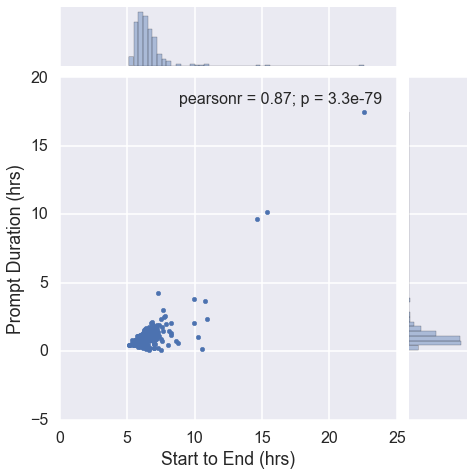

In [36]:
sns.jointplot(data= overall_df.dropna(subset=['Prompt Duration (hrs)']),
              x= 'Start to End (hrs)',
              y= 'Prompt Duration (hrs)',
              size = 7)

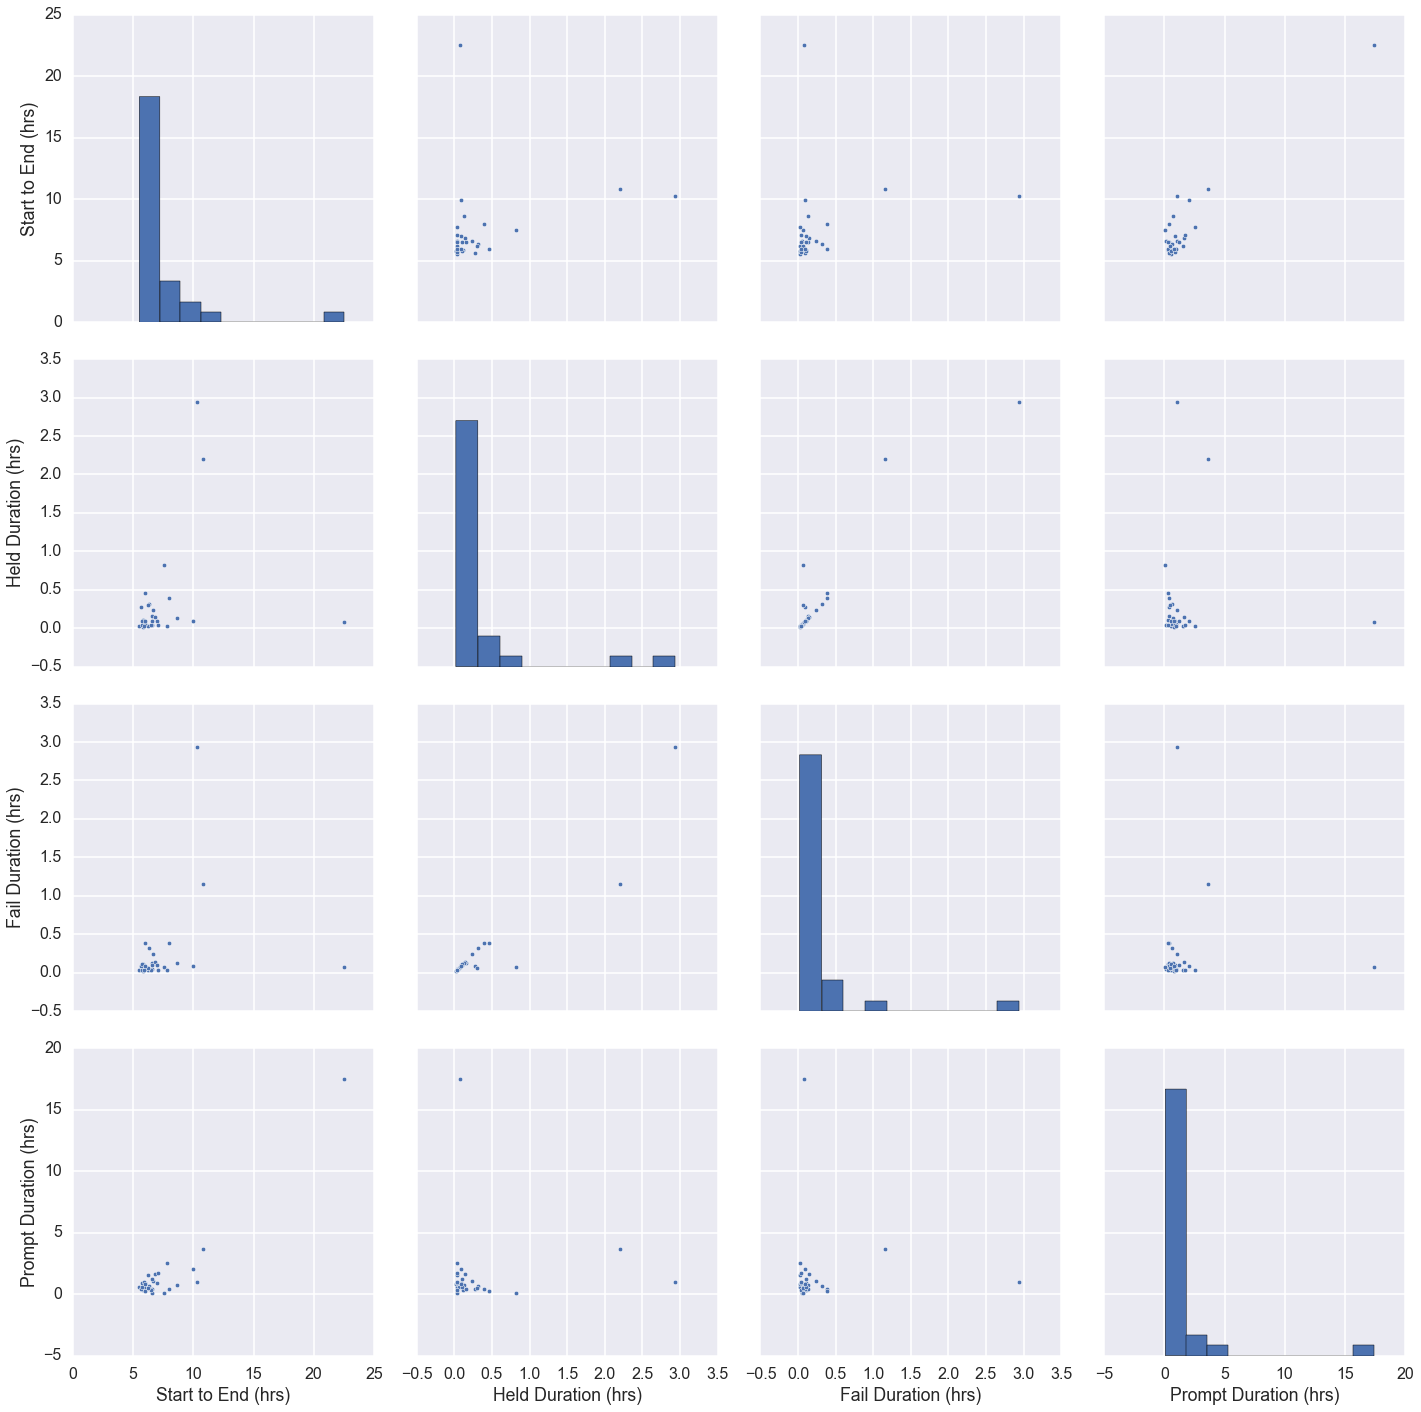

In [37]:
sns.pairplot(data=overall_df.dropna(),
             vars=['Start to End (hrs)',
                   'Held Duration (hrs)',
                   'Fail Duration (hrs)',
                   'Prompt Duration (hrs)'],size=5)

## File output

In [38]:
writer = pd.ExcelWriter('FP2 held and failed durations.xlsx')
overall_df.to_excel(writer,'Overall Times', columns = ['BatchID',
                                                       'Start Time',
                                                       'End Time',
                                                       'Start to End (hrs)',
                                                       'Held Duration (hrs)',
                                                       'Fail Duration (hrs)',
                                                       'Prompt Duration (hrs)'])

heldDurationInfo_df.to_excel(writer,'Held Durations', columns = ['BatchID',
                                                                 'Action',
                                                                 'Held Start Time',
                                                                 'Held End Time',
                                                                 'Held Duration (hrs)'])

failDurationInfo_df.to_excel(writer,'Failed Durations',columns = ['BatchID',
                                                                  'Fail Message',
                                                                  'Fail Start Time',
                                                                  'Fail End Time',
                                                                  'Fail Duration (hrs)'])

promptDurationInfo_df.to_excel(writer,'Prompt Durations',columns = ['BatchID',
                                                                    'Prompt',
                                                                    'Prompt Duration (hrs)'])
writer.save()